# Testing how to implement Piecewise Layers

## TODO:
1. Figure out how to do batching with this code
2. Ensure this is the most efficient
3. Polish up the mess

In [1]:
%pylab inline
import numpy as np
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Use eager execution to make debugging easier (causes tensorflow to evaluate functions immediately)
tf.enable_eager_execution()

In [50]:
def one_hot_matrix(b,K):
    return tf.one_hot(tf.squeeze(b),K,axis=1)

## Piecewise Linear

In [3]:
# Create bin array with nbins, each with a width of 1.0/nbins. 
# Note: the bins array contains the bin edges including 0, which makes finding alpha easier later on
nbins = 5
width = 1.0/nbins
bins = np.array([[x*width for x in range(nbins+1)] for i in range(3)])

# Print bins for testing purposes
bins

array([[0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ]])

In [13]:
# randomly assign unnormalized values to piecewise PDF, here we will be using a total of 6 dimensions (|B|=3)
Q = np.random.rand(3,nbins)

# normalize the piecewise PDF such that the integral is 1
Q = tf.nn.softmax(Q)

# Insert a 0 to the beginning to match the size to the bin array
Q = np.insert(Q,0,0,axis=1)

# Print out values of Q for testing purposes
Q

array([[0.        , 0.21680817, 0.17064866, 0.26105784, 0.10922443,
        0.2422609 ],
       [0.        , 0.16621744, 0.20854217, 0.31735254, 0.14103344,
        0.16685442],
       [0.        , 0.21278925, 0.18665439, 0.20712098, 0.13012552,
        0.26330986]])

In [12]:
Q[np.arange(len(Q)),[2,3,1]]
np.cumsum(Q,axis=1)[np.arange(len(Q)),[2,3,1]]

array([0.28888006, 0.66944252, 0.31280239])

In [106]:
# Generate a single phase space point in xB
xB = np.random.rand(1,3)

# Print out xB for testing purposes
xB

array([[0.47401404, 0.83638037, 0.32838019]])

In [77]:
# searchsorted finds the location that each xB should be inserted into bins in order to keep the bins array sorted
# The transpose is needed to make sure that each point is compared to the right dimension
b=tf.searchsorted(bins,tf.transpose(xB),side='right')

# The result returns a transpose of a bin location array, take the transpose and print for testing
tf.transpose(b).numpy()

array([[32, 29, 10]], dtype=int32)

In [78]:
# Test to ensure that the correct Q values are pulled out from the arrays
# Note: that each dimension pulls out each bin, there may be a way around this, 
#       but the desired result is on the diagonal
mask = one_hot_matrix(b,len(bins[0]))
tf.reduce_prod((Q*mask).numpy().ravel()[np.flatnonzero(Q*mask)])

<tf.Tensor: id=4185686, shape=(), dtype=float32, numpy=3.9705589e-07>

In [79]:
mask

<tf.Tensor: id=4185673, shape=(3, 33), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)>

In [80]:
# This calculates the PDF for the Piecewise Linear layer, 
# it takes the result from above and takes the product of the diagonal.
# Again there may be a better way to do this
tf.reduce_prod(tf.diag_part(Q[:,b[:,0]])).numpy()

3.9705586096344466e-07

In [81]:
# Calculate the alpha value in each dimension. 
# Note: the -1 in the bins term, this is to use the left edge of the bin instead of the right edge
alpha = (xB-tf.diag_part(bins[:,b[:,0]-1]))/width

# Print out the values of alpha for testing
alpha.numpy()

array([[0.08688591, 0.72081828, 0.80491096]])

In [91]:
# Calculates the first part of the coupling layer term (\alpha Q_{ib}) in each dimension
tf.diag_part(alpha*Q[:,b[:,0]]).numpy()

array([0.00027781, 0.00165528, 0.04352697])

In [89]:
# Calculates the second part of the coupling layer term (sum_{k=1}^{b-1} Q_{ik}) in each dimension
# There may be a more efficient way of doing this.
tf.diag_part(np.cumsum(Q,axis=1)[:,b[:,0]-1]).numpy()

array([0.9968026 , 0.82434687, 0.30808669])

In [93]:
# Calculates the full coupling layer terms
(tf.diag_part(alpha*Q[:,b[:,0]])+tf.diag_part(np.cumsum(Q,axis=1)[:,b[:,0]-1])).numpy()

array([0.99708041, 0.82600214, 0.35161366])

In [144]:
x=np.linspace(0,1,100,endpoint=False)
a = np.zeros_like(x)
tot = np.zeros_like(x)
for i,_ in enumerate(x):
    a[i] = Q[0,int(np.floor(5*x[i]+1))]
    tot[i] = np.sum(Q[0,:int(np.floor(5*x[i]+1))])
C=(5*x-np.floor(5*x))*a+tot

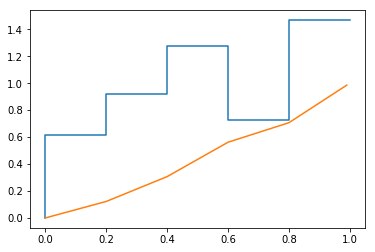

In [146]:
plt.plot(bins[0],Q[0]/width,ls='steps')
plt.plot(x,C)
plt.show()

## Layer Class

In [ ]:
class